In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import fashion_mnist, plot_graphs, plot_imgs
import numpy as np
import seaborn as sns

sns.set()

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
pin_memory = torch.cuda.is_available()
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.6.0  Device: cuda


In [3]:
train_loader, valid_loader, test_loader = fashion_mnist(batch_size=64, valid=10000, pin_memory=True, num_workers=2)

In [4]:
a = next(iter(train_loader))

In [5]:
imgs = a[0].squeeze()
shape = [8,8]

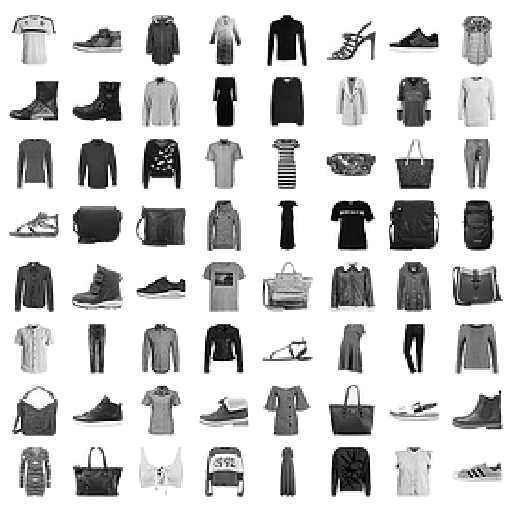

In [6]:
plot_imgs(imgs, shape )

In [4]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        w = 128 * 20
        self.fc1 = nn.Linear(28*28, w)
        self.fc2 = nn.Linear(w, w)
        self.fc3 = nn.Linear(w, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(w)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=0)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        
#         data = data.to(device)
#         target = target.to(device)
        pin_memory = False
        data, target = data.cuda(non_blocking=pin_memory), target.cuda(non_blocking=pin_memory)
    
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [6]:
models = {'default': Net(False, False).to(device), 'bn': Net(True, False).to(device), 'drop': Net(False, True).to(device), 'both': Net(True, True).to(device)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
#             data = data.to(device)
#             target = target.to(device)
            data, target = data.cuda(non_blocking=pin_memory), target.cuda(non_blocking=pin_memory)
        
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [8]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.310562 bn: 2.369518 drop: 2.298898 both: 2.306412
Train Epoch: 1 [12800/50000 (26%)]	Losses default: 0.479323 bn: 0.414116 drop: 0.513750 both: 0.410468
Train Epoch: 1 [25600/50000 (51%)]	Losses default: 0.438086 bn: 0.396055 drop: 0.445833 both: 0.426999
Train Epoch: 1 [38400/50000 (77%)]	Losses default: 0.399092 bn: 0.372564 drop: 0.401039 both: 0.418510
Train Epoch: 1 [12512/50000 (100%)]	Losses default: 0.365899 bn: 0.335368 drop: 0.344945 both: 0.308844
Test set:
default: Loss: 0.3728	Accuracy: 8668.0/10000 (87%)
bn: Loss: 0.3435	Accuracy: 8755.0/10000 (88%)
drop: Loss: 0.3860	Accuracy: 8609.0/10000 (86%)
both: Loss: 0.3543	Accuracy: 8699.0/10000 (87%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.363759 bn: 0.353247 drop: 0.372651 both: 0.370677
Train Epoch: 2 [12800/50000 (26%)]	Losses default: 0.221222 bn: 0.277785 drop: 0.266726 both: 0.313318
Train Epoch: 2 [25600/50000 (51%)]	Losses default: 0.402609 bn: 0.376284 drop: 0.452

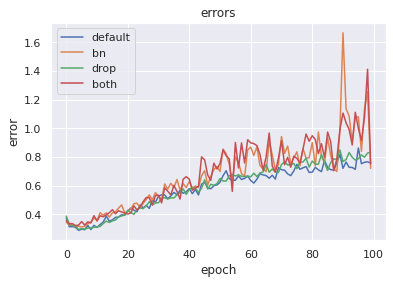

In [9]:
plot_graphs(test_log, 'loss')

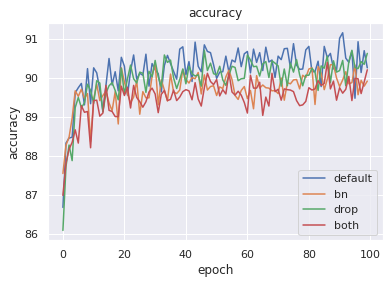

In [10]:
plot_graphs(test_log, 'accuracy')

In [14]:
img, val = next(iter(valid_loader))

In [18]:
outputs = models['bn'](img)
# print(outputs)

_, predicted = torch.max(outputs, 1)

print(f'Predicted: {predicted.cpu().numpy()}')

Predicted: [1 3 2 3 6 1 7 2 5 2 5 6 9 0 1 3 6 6 3 3 3 6 5 8 5 3 7 3 1 4 8 7 7 8 9 3 1
 0 8 7 2 8 2 2 8 5 2 3 6 2 1 1 2 7 3 3 9 1 2 7 4 2 3 2]


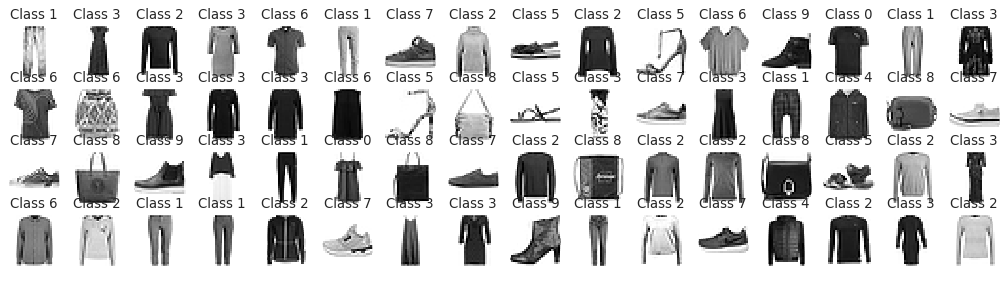

In [24]:
from utils import plot_mnist
plot_mnist(img, [4, 16], list(predicted.cpu().numpy()))

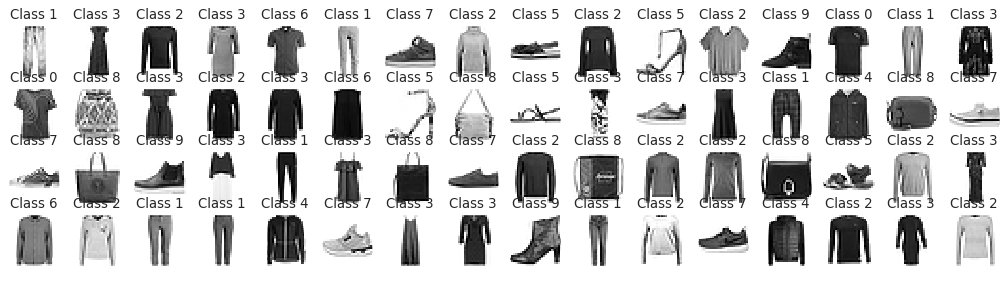

In [26]:
plot_mnist(img, [4, 16], list(val))